# Mid-Distance Performance Analysis

This is an analysis of the relationships between middle-distance events. I'm mostly interested in the 800, but the general idea is to be able to predict a certain race's outcome based on your performance in other events. Particularly, being able to predict your 800m time based off of your 400m and/or 1500m/mile time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
from model import DataModel, plot_eda

## TFRRS Data

The links in the following dictionary have been obtained by going to the TFRRS database archives, finding the men's 800m for the desired season/year, inspecting the table, and finding the src argument of the turbo-frame tag with id = 'list_data'. There are some patterns in the URLs, but the only consistent ones are the ones I've already automated. There are still random differences at times between divisions and between indoor and outdoor seasons.

[Example](https://tf.tfrrs.org/lists/3901/2022_2023_NCAA_Div_I_Indoor_Qualifying_FINAL):

> `<turbo-frame id="list_data" src="https://tf.tfrrs.org/list_data/3901?other_lists=`
> `https%3A%2F%2Fm.tfrrs.org%2Flists%2F3901%2F2022_2023_NCAA_Div_I_Indoor_Qualifying`
> `_FINAL&amp;limit=100&amp;event_type=53&amp;year=&amp;gender="> ... </turbo-frame>`

In [2]:
di_dict = {
    'indoor_2022': 'https://tf.tfrrs.org/list_data/3492?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F3492%2F2021_2022_NCAA_Div_I_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2022': 'https://tf.tfrrs.org/list_data/3711?other_lists=https%3A%2F%2Fxc.tfrrs.org%2Flists%2F3711%2F2022_NCAA_Division_I_Outdoor_Qualifying_FINAL&limit=500&event_type=12&year=&gender=m',
    'indoor_2023': 'https://tf.tfrrs.org/list_data/3901?other_lists=https%3A%2F%2Fm.tfrrs.org%2Flists%2F3901%2F2022_2023_NCAA_Div_I_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2023': 'https://tf.tfrrs.org/list_data/4044?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F4044%2F2023_NCAA_Division_I_All_Schools_Rankings&limit=500&event_type=12&year=&gender=m',
    'indoor_2024': 'https://tf.tfrrs.org/list_data/4364?other_lists=https%3A%2F%2Fmobile.tfrrs.org%2Flists%2F4364%2F2023_2024_NCAA_Div_I_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
}

def create_dx_dict(dict: dict, division: str) -> dict:
    '''Updates the values of the DI dictionary to correspond with DII and DIII URLs. There are still some inconsistencies, so some values will have to be manually fixed after the function.
    
    Parameters:
        dict (dict): the NCAA DI Dictionary of URLs
        division (str): 'II' or 'III' to match DII or DIII
        
    Returns:
        dx_dict (dict): a dict with updated values to match the corresponding NCAA division'''
    
    dx_dict = {}
    for season in dict:
        new_url = dict[season].replace('_I_', f'_{division}_')

        table_id = dict[season].split('?')[0][-4:]
        new_table_id = str(int(table_id) + len(division))
        new_url = new_url.replace(table_id, new_table_id)
        
        dx_dict[season] = new_url

    return dx_dict


dii_dict = create_dx_dict(di_dict, 'II')     
dii_dict['outdoor_2022'] = 'https://tf.tfrrs.org/list_data/3595?other_lists=https%3A%2F%2Fupload.tfrrs.org%2Flists%2F3595%2F2022_NCAA_Division_II_Outdoor_Qualifying_FINAL&limit=500&event_type=12&year=&gender=m'

diii_dict = create_dx_dict(di_dict, 'III')
diii_dict['indoor_2024'] = 'https://tf.tfrrs.org/list_data/4366?other_lists=https%3A%2F%2Fupload.tfrrs.org%2Flists%2F4366%2F2023_2024_NCAA_Div_III_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m'

naia_dict = {
    'indoor_2022': 'https://tf.tfrrs.org/list_data/3495?other_lists=https%3A%2F%2Fwww.tfrrs.org%2Flists%2F3495%2F2021_2022_NAIA_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2022': 'https://tf.tfrrs.org/list_data/3596?other_lists=https%3A%2F%2Fwww.tfrrs.org%2Flists%2F3596%2F2022_NAIA_Outdoor_Qualifying_List_FINAL&limit=500&event_type=12&year=&gender=m',
    'indoor_2023': 'https://tf.tfrrs.org/list_data/3904?other_lists=https%3A%2F%2Fwww.tfrrs.org%2Flists%2F3904%2F2022_2023_NAIA_Indoor_Qualifying_List_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2023': 'https://tf.tfrrs.org/list_data/4046?other_lists=https%3A%2F%2Fmobile.tfrrs.org%2Flists%2F4046%2F2023_NAIA_Outdoor_Qualifying_FINAL&limit=500&event_type=12&year=&gender=m',
    'indoor_2024': 'https://tf.tfrrs.org/list_data/4368?other_lists=https%3A%2F%2Fm.tfrrs.org%2Flists%2F4368%2F2023_2024_NAIA_Indoor_Qualifying_List_FINAL&limit=500&event_type=54&year=&gender=m',
}

njcaa_dict = {
    'indoor_2022': 'https://tf.tfrrs.org/list_data/3496?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F3496%2F2021_2022_NJCAA_Indoor_Qualifying_List&limit=500&event_type=54&year=&gender=m',
    'outdoor_2022': 'https://tf.tfrrs.org/list_data/3717?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F3717%2FNJCAA_All_Schools_Outdoor_Performance_List&limit=500&event_type=12&year=&gender=m',
    'indoor_2023': 'https://tf.tfrrs.org/list_data/3905?other_lists=https%3A%2F%2Fmobile.tfrrs.org%2Flists%2F3905%2F2022_2023_NJCAA_Indoor_Qualifying_List&limit=500&event_type=54&year=&gender=m',
    'outdoor_2023': 'https://tf.tfrrs.org/list_data/4201?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F4201%2FNJCAA_All_Schools_Outdoor_Performance_List&limit=500&event_type=12&year=&gender=m',
    'indoor_2024': 'https://tf.tfrrs.org/list_data/4367?other_lists=https%3A%2F%2Fm.tfrrs.org%2Flists%2F4367%2F2023_2024_NJCAA_Indoor_Qualifying_List&limit=500&event_type=54&year=&gender=m',
}

### 800m and 400m

In [3]:
from scrape_tfrrs import TFRRSScraper

tfrrs_400 = TFRRSScraper(400)
if not glob(f'data/tfrrs*{tfrrs_400.other_event}.csv'):
    di_tfrrs_400 = tfrrs_400.download_seasons(di_dict, division='di')
    dii_tfrrs_400 = tfrrs_400.download_seasons(dii_dict, division='dii')
    diii_tfrrs_400 = tfrrs_400.download_seasons(diii_dict, division='diii')
    naia_tfrrs_400 = tfrrs_400.download_seasons(naia_dict, division='naia')
    njcaa_tfrrs_400 = tfrrs_400.download_seasons(njcaa_dict, division='njcaa')
    df_tfrrs_400 = tfrrs_400.merge_tfrrs_data()
else:
    print(f'[INFO] TFRRS {tfrrs_400.other_event}m data found in data directory')
    df_tfrrs_400 = tfrrs_400.merge_tfrrs_data()

[INFO] TFRRS 400m data found in data directory


<Axes: title={'center': '400m vs 800m\nn=3,285'}, xlabel='time_400', ylabel='time_800'>

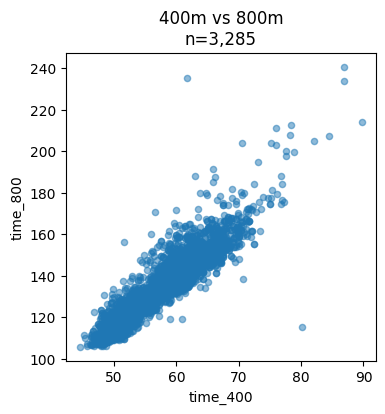

In [4]:
df_tfrrs_400.plot(
    kind='scatter',
    x='time_400',
    y='time_800',
    figsize=(4,4),
    alpha = 0.5,
    title = f'400m vs 800m\nn={len(df_tfrrs_400):,}'
)

### 800m and 1500m

In [5]:
tfrrs_1500 = TFRRSScraper(1500)
if not glob(f'data/tfrrs*{tfrrs_1500.other_event}.csv'):
    di_tfrrs_1500 = tfrrs_1500.download_seasons(di_dict, division='di')
    dii_tfrrs_1500 = tfrrs_1500.download_seasons(dii_dict, division='dii')
    diii_tfrrs_1500 = tfrrs_1500.download_seasons(diii_dict, division='diii')
    naia_tfrrs_1500 = tfrrs_1500.download_seasons(naia_dict, division='naia')
    njcaa_tfrrs_1500 = tfrrs_1500.download_seasons(njcaa_dict, division='njcaa')
    df_tfrrs_1500 = tfrrs_1500.merge_tfrrs_data()
else:
    print(f'[INFO] TFRRS {tfrrs_1500.other_event}m data found in data directory')
    df_tfrrs_1500 = tfrrs_1500.merge_tfrrs_data()

[INFO] TFRRS 1500m data found in data directory


<Axes: title={'center': '1500m vs 800m\nn=10,030'}, xlabel='time_1500', ylabel='time_800'>

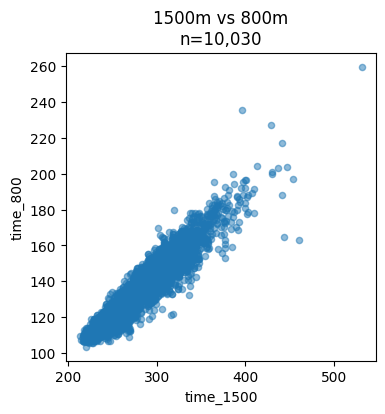

In [6]:
df_tfrrs_1500.plot(
    kind='scatter',
    x='time_1500',
    y='time_800',
    figsize=(4,4),
    alpha = 0.5,
    title = f'1500m vs 800m\nn={len(df_tfrrs_1500):,}'
)

# df_tfrrs_1500.loc[(df_tfrrs_1500['time_800'] < 210) & 
#                   (df_tfrrs_1500['time_1500'] < 425)]

## MileSplit Data

I ran the MileSplitScraper in terminal because it was performing faster. Each complete run took about 3-4 hours.

In [7]:
if not glob('data/milesplit*.csv'):
    !python scrape_milesplit.py
else:
    print('[INFO] MileSplit data found in data directory')
    df_milesplit_400 = pd.read_csv('data/milesplit_indoor_2020-outdoor_2024_400m.csv').drop_duplicates()
    df_milesplit_mile = pd.read_csv('data/milesplit_indoor_2020-outdoor_2024_Mile.csv')
    df_milesplit_1600 = pd.read_csv('data/milesplit_indoor_2020-outdoor_2024_1600m.csv')


[INFO] MileSplit data found in data directory


### 800m vs 400m

<Axes: title={'center': '400m vs 800m\nn=6,097'}, xlabel='time_400', ylabel='time_800'>

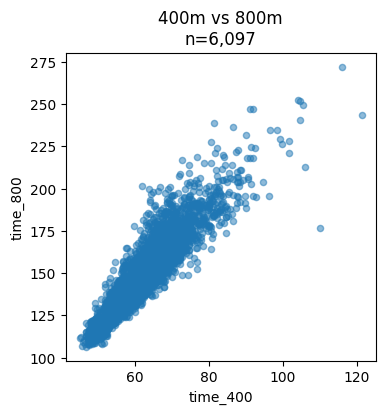

In [8]:
df_milesplit_400.plot(
    kind='scatter',
    x='time_400',
    y='time_800',
    figsize=(4,4),
    alpha = 0.5,
    title = f'400m vs 800m\nn={len(df_milesplit_400):,}'
)

### 800m vs 1500m converted from the 1600m or Mile

<Axes: title={'center': 'Mile -> 1500m vs 800m\nn=4,641'}, xlabel='time_1500', ylabel='time_800'>

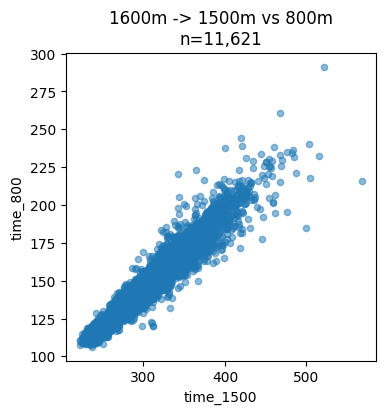

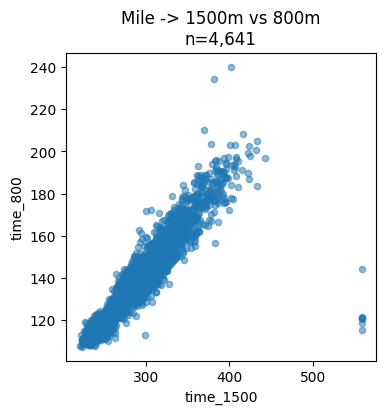

In [9]:
df_milesplit_1600.plot(
    kind='scatter',
    x='time_1500',
    y='time_800',
    figsize=(4,4),
    alpha = 0.5,
    title = f'1600m -> 1500m vs 800m\nn={len(df_milesplit_1600):,}'
)

df_milesplit_mile.plot(
    kind='scatter',
    x='time_1500',
    y='time_800',
    figsize=(4,4),
    alpha = 0.5,
    title = f'Mile -> 1500m vs 800m\nn={len(df_milesplit_mile):,}'
)

## EDA and Data Cleaning

### Combined Data Sources

#### 800m vs 400m 

##### Before Cleaning

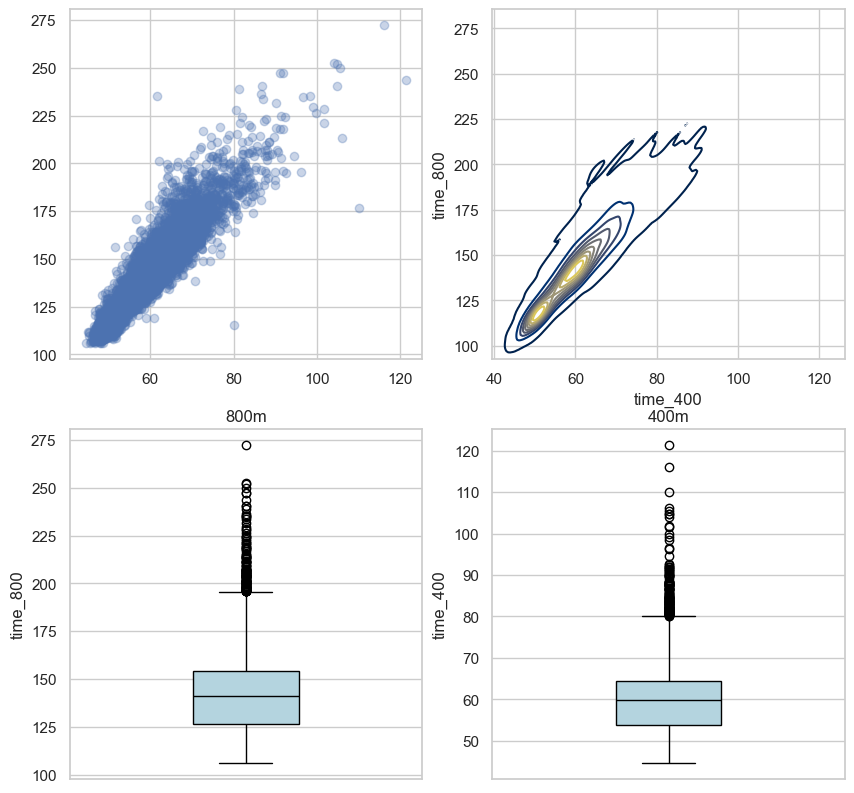

In [27]:
df_400 = pd.concat([df_tfrrs_400, df_milesplit_400])
plot_eda(df_400, 400)

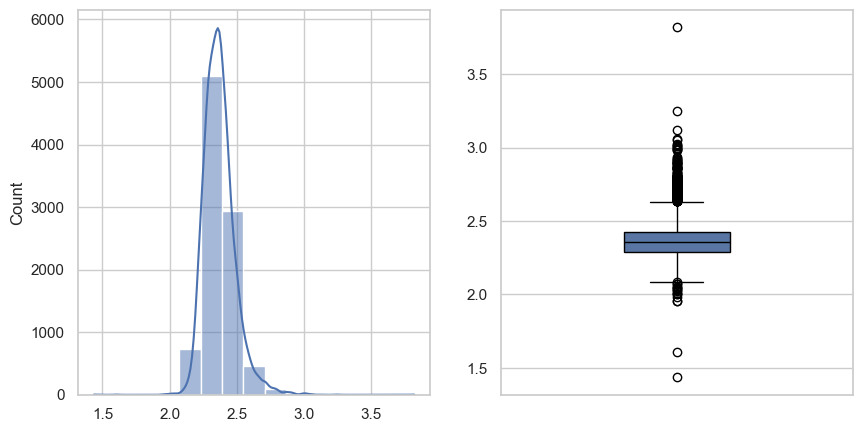

In [11]:
# Find metric to describe outliers
metric = (df_400['time_800'] / df_400['time_400'])

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.histplot(metric, 
             bins=int(np.ceil(np.log2(len(metric)) + 1)),
             kde=True)

plt.subplot(1,2,2)
sns.boxplot(y=metric.values, width=0.3, linecolor='black')
plt.show()

##### Cleaned Data

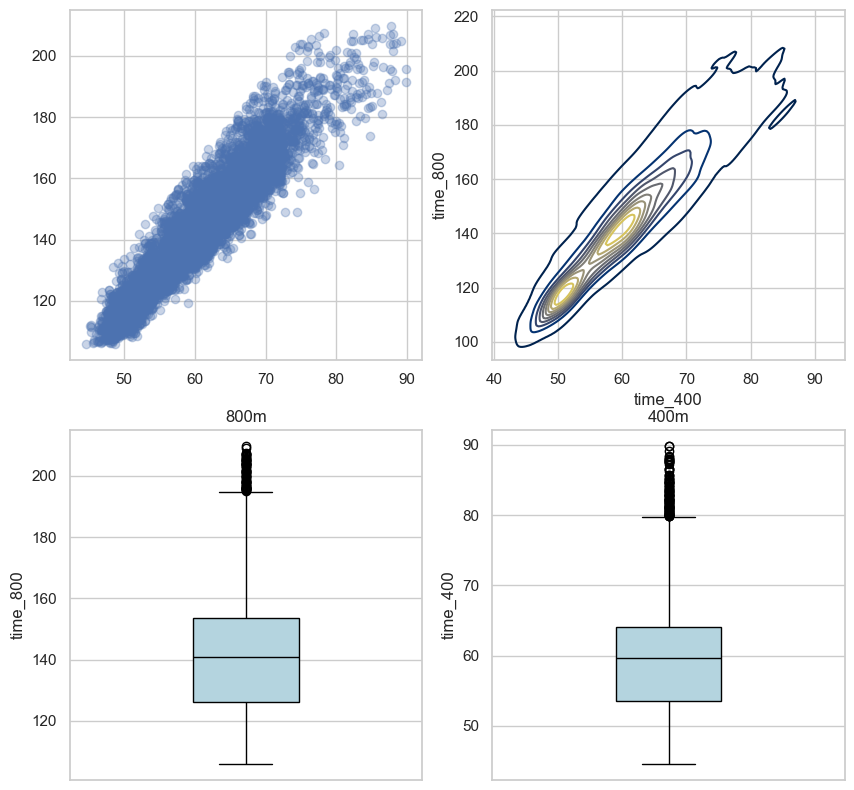

In [12]:
# Remove tails that aren't representative of the rest of the data
df_400 = df_400.loc[(df_400['time_800'] < 210) & (df_400['time_400'] < 90)]

# Remove unrealistic 400 vs 800 times/the new outlier metric
df_400 = df_400.loc[(df_400['time_800'] / df_400['time_400'] > 2) & (df_400['time_800'] / df_400['time_400'] < 2.75)]

# Visualize
plot_eda(df_400, 400)

Might need to model both data sources separately. Taking random samples and averaging obviously removes the fastest (and slowest) times for modeling.

#### Create Random Sample Groups

In [13]:
df_400['idx'] = range(len(df_400))
df_400.set_index('idx', inplace=True)

SAMPLE_SIZE = 40
N_GROUPS = int(np.ceil(len(df_400) / SAMPLE_SIZE))

df_400_shuffle = df_400.sample(frac=1, random_state=69420)
df_400_shuffle['sample_group'] = (list(range(N_GROUPS)) * SAMPLE_SIZE)[:len(df_400)]

df_400_sampled = df_400_shuffle.select_dtypes('number') \
    .groupby('sample_group') \
    .mean() \
    .round(2)

## Modelling

### Combined Data Sources

#### 800m vs 400m 

In [ ]:
model_400 = DataModel(df_400_sampled, 400, 'ols')
model_400_robust = DataModel(df_400_sampled, 400, 'rlm')

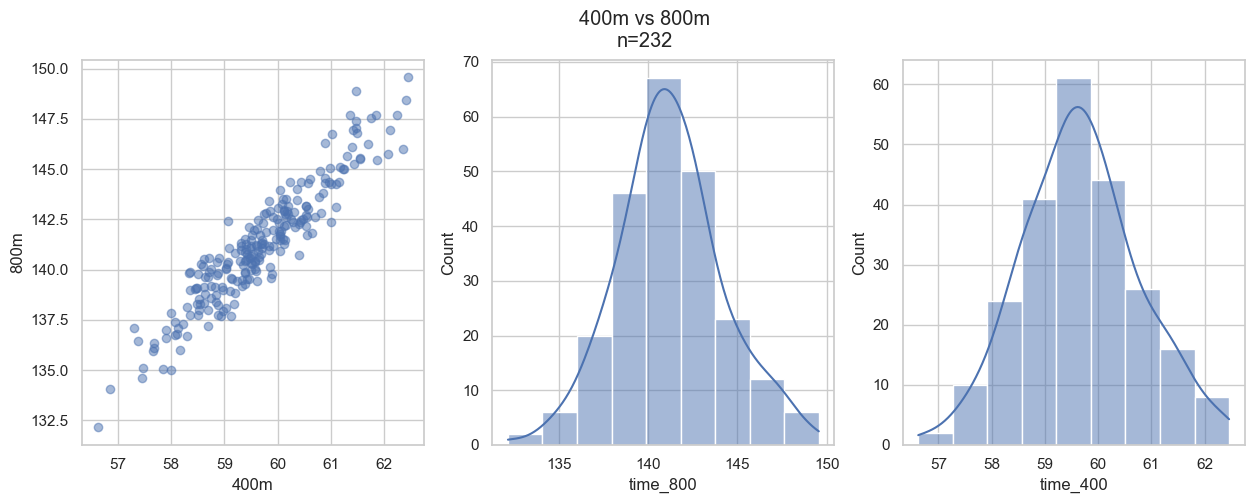

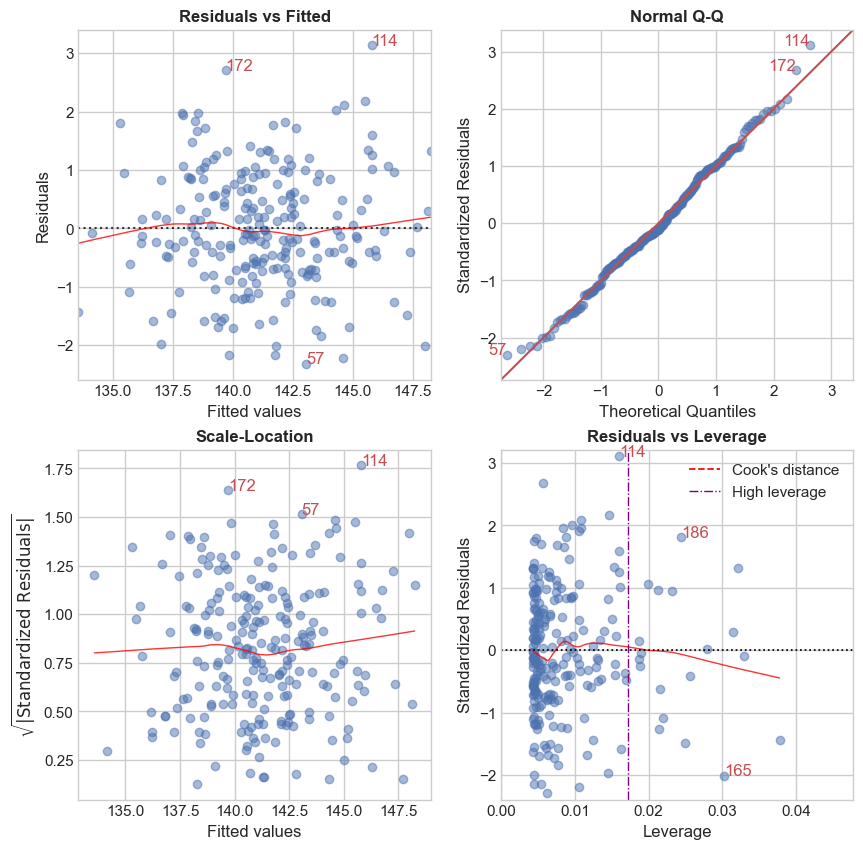

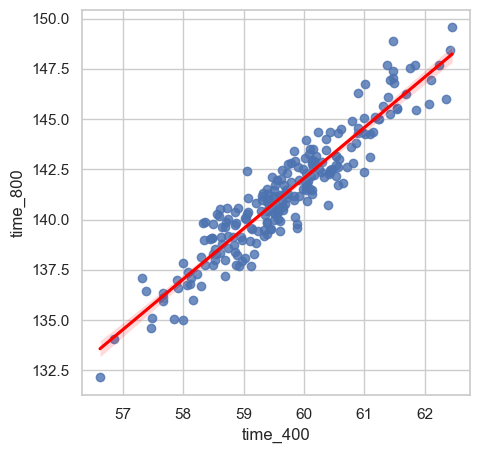

In [14]:
model_400.plot_dist()
model_400.check_assumptions()
model_400.plot_conf_int()

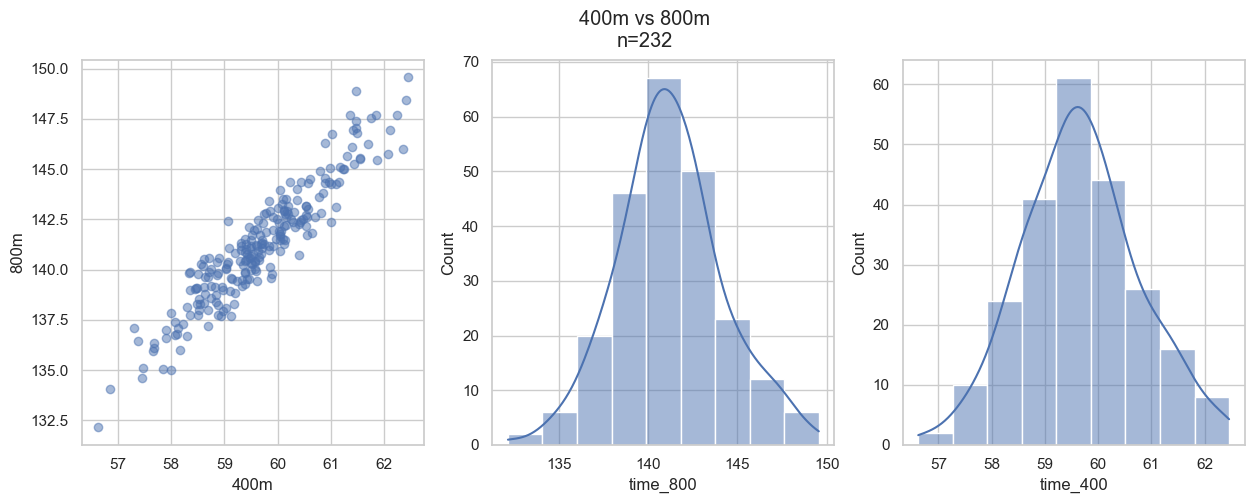

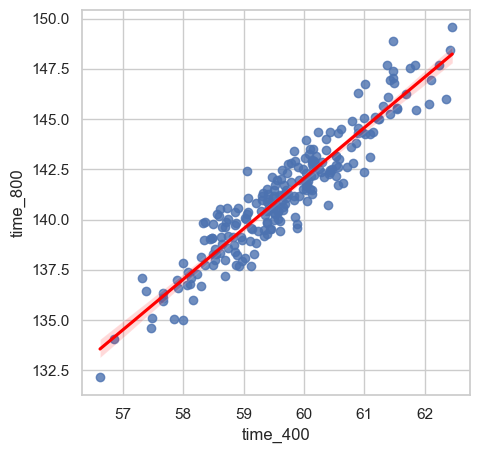

In [15]:
model_400_robust.plot_dist()
model_400_robust.check_assumptions()
model_400_robust.plot_conf_int()

In [25]:
model_400.model.params

Intercept   -8.555983
time_400     2.510335
dtype: float64

In [20]:
model_400.model.conf_int()

,0,1
Intercept,-15.693942,-1.418023
time_400,2.390738,2.629932


In [26]:
model_400_robust.model.params

Intercept   -8.675969
time_400     2.512235
dtype: float64

In [22]:
model_400_robust.model.conf_int()

,0,1
Intercept,-15.930489,-1.421449
time_400,2.390685,2.633786


[More diagnostics](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html)